In [1]:
!pip install datasets tokenizers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import datasets
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

device : cuda


In [60]:
dataset_train , dataset_test = load_dataset("silicone","dyda_da",split=['train[:100%]','test[:100%]'])
dataset = datasets.DatasetDict({"train" : dataset_train,"test":dataset_test})
dataset = dataset.rename_column("Label", "labels")
dataset = dataset.rename_column("Utterance", "text")
idx2label = {idx:label for idx, label in enumerate(dataset['train'].features['labels'].names)}
idx2label

  0%|          | 0/2 [00:00<?, ?it/s]

{0: 'commissive', 1: 'directive', 2: 'inform', 3: 'question'}

In [44]:
def preprocess(data):
    tokenized_text = tokenizer(data['text'], padding=True, truncation=True, max_length=64)
    tokenized_text['labels'] = data['labels']
    return tokenized_text

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
encoded_dataset = dataset.map(preprocess, batched=True, 
                              remove_columns=['Dialogue_Act','Dialogue_ID','Idx'])
encoded_dataset.set_format("torch")

Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

In [45]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = 4, 
    output_attentions = False, 
    output_hidden_states = True,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [46]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.bert.encoder.layer[-1:].parameters():
    param.requires_grad = True

## Check parameters

In [47]:
# Get all of the model's parameters as a list of tuples.
model.named_parameters()

total_n_weights = sum(list(map(lambda param: param[1].flatten().size()[0], model.named_parameters())))
trainable_weights = sum(list(map(lambda param:
                                 param.flatten().size()[0] if param.requires_grad
                                 else 0, model.parameters())))

print('Total weights:', total_n_weights)
print('Trainable weights:', trainable_weights)

params = list(model.named_parameters())
print('\nThe BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Total weights: 108313348
Trainable weights: 7087872

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encod

In [ ]:
args = {
    'batch_size': 8,
    'epochs': 5,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'epsilon': 1e-8,
}

In [ ]:
# load data
train_data = encoded_dataset['train']
test_data = encoded_dataset['test']
train_loader = DataLoader(train_data, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=args['batch_size'])

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=args['learning_rate'], eps=args['epsilon'])
total_steps = len(train_loader) * args['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'],
                                             num_training_steps=total_steps)

# define loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for d in train_loader:
  input_ids = d["input_ids"].to(device)
  attention_mask = d["attention_mask"].to(device)
  targets = d["labels"].to(device)
  outputs = model(
    input_ids=input_ids,
    #attention_mask=attention_mask
  )
  break

In [ ]:
outputs['pooler_output'].shape

torch.Size([8, 768])

In [ ]:
# define training loop
def train_loop(model, data_loader, optimizer, scheduler, loss_fn):
    model.train()
    losses = []
    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, token_type_ids, attention_mask)
        logits = outputs['logits']
        loss = loss_fn(logits, labels)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = sum(losses) / len(losses)
    return avg_loss

# define evaluation function
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(data_loader, desc="Evaluating", leave=False):
        input_ids = batch['input_ids'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, token_type_ids, attention_mask)
        logits = outputs['logits']
        _, predicted = torch.max(logits, 1)

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

    return accuracy_score(true_labels, predictions)

In [ ]:
# train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
for epoch in range(args['epochs']):
    train_loss = train_loop(model, train_loader, optimizer, scheduler, loss_fn)
    test_acc = evaluate(model, test_loader)
    print(f'Epoch {epoch + 1}/{args["epochs"]} - Train loss: {train_loss:.3f} - Test accuracy: {test_acc:.3f}')

# Contextual Model

In [48]:
from transformers import BertModel, BertTokenizer
from collections import defaultdict
from torch.utils.data import Dataset,  DataLoader

In [49]:
# Define all parameters
args = {'max_sentence': 16,
        'max_word': 32,
        'bsize': 4,
        'device': device,
        'num_class': 5,
        'class_weights': torch.tensor([1., 1., 1., 1., 0.]),
        'bert_output_size': 768, 'lstm_hidden_dimension':768, 'lstm_layers':2,
        'unfreezed_bert_layer': 3,
        'dropout': 0.5, 'lr': 1e-4, 'epochs': 3}

max_sentence_per_dialog = args['max_sentence']
max_word_per_sentence = args['max_word']

### Format data

In [61]:
dataset_train , dataset_test = load_dataset("silicone","dyda_da",split=['train[:100%]','test[:100%]'])
dataset = datasets.DatasetDict({"train" : dataset_train,"test":dataset_test})
dataset = dataset.rename_column("Label", "labels")
dataset = dataset.rename_column("Utterance", "text")

  0%|          | 0/2 [00:00<?, ?it/s]

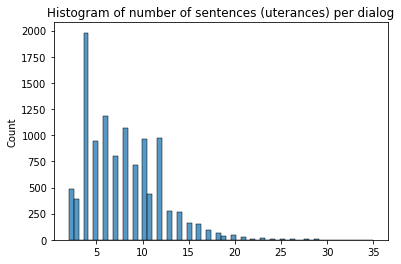

In [62]:
sns.histplot(np.unique(dataset['train'][:]['Dialogue_ID'], return_counts=True)[1])
plt.title('Histogram of number of sentences (uterances) per dialog')
plt.show()

In [63]:
# define BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
vocab_stoi = tokenizer.get_vocab()

In [64]:
def tokenize_pad_numericalize_dialog(entry, vocab_stoi, max_length=32):
  ''' message level '''
  dialog = [[vocab_stoi['[CLS]']]
            + [vocab_stoi[token] if token in vocab_stoi else vocab_stoi['[UNK]'] for token in tokenizer.tokenize(e.lower()) ] 
            + [vocab_stoi['[SEP]']]
            for e in entry]
  padded_dialog = list()
  for d in dialog:
    if len(d) < max_length: 
        padded_dialog.append(d + [ vocab_stoi['[PAD]'] for i in range(len(d), max_length)])
    elif len(d) > max_length:
        padded_dialog.append(d[:max_length])
    else:           
         padded_dialog.append(d) 
  
  return padded_dialog

def tokenize_all_dialog(entries, vocab_stoi, max_message_length=max_word_per_sentence,
                         max_dialog_length=max_sentence_per_dialog):
    ''' dialog level '''
    pad_message = [ vocab_stoi['[PAD]'] ]
    pad_label = [4] # because our labels go from 0 to 3
    res_dialog, res_labels = [], []

    # Group messages by dialogue ID
    dialogues = defaultdict(list)
    dialogue_labels = defaultdict(list)
    for i in range(len(entries['text'])):
        dialogue_id = entries['Dialogue_ID'][i]
        dialogues[dialogue_id].append(entries['text'][i])
        dialogue_labels[dialogue_id].append(entries['labels'][i])

    # Tokenize and pad messages for each dialogue
    for dialogue_id, text in dialogues.items():
        # entry = text.strip().split(' | ')[1:]  # Remove speaker ID
        labels = dialogue_labels[dialogue_id]
        text = tokenize_pad_numericalize_dialog(text, vocab_stoi, max_length=max_message_length)
        if len(text) < max_dialog_length:
            text = text + [[vocab_stoi['[PAD]']] * max_message_length for i in range(len(text), max_dialog_length)]
            labels = labels +pad_label * (max_dialog_length-len(labels))
        elif len(text) > max_dialog_length:
            text = text[-max_dialog_length:]
            labels = labels[-max_dialog_length:]
        res_dialog.append(text)
        res_labels.append(labels)

    res = {'text': res_dialog, 'labels': res_labels}
    return res

encoded_dataset = dataset.map(lambda e: tokenize_all_dialog(e, vocab_stoi), batched=True, 
                              remove_columns=['Dialogue_Act','Dialogue_ID','Idx'])
encoded_dataset.set_format("torch")

Map:   0%|          | 0/87170 [00:00<?, ? examples/s]

Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

In [65]:
class DialogActDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['labels'])
      }
      return item

In [66]:
train_loader = DataLoader(DialogActDataset(encoded_dataset['train'], args), batch_size=args['bsize'], shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(encoded_dataset['test'], args), batch_size=args['bsize'], shuffle=True, drop_last=True)

## define Model

In [67]:
class BiLSTM(nn.Module):
    def __init__(self, args):
        super(BiLSTM, self).__init__()

        self.args = args # TODO : sortir du args ce qui est nécessaire
        self.bert_model = BertModel.from_pretrained('bert-base-cased')

        # Freeze some Bert Layers
        for param in self.bert_model.parameters():
            param.requires_grad = False
        # Unfreeze the last layer
        for param in self.bert_model.encoder.layer[-args['unfreezed_bert_layer']:].parameters():
            param.requires_grad = True

        # Dimensions are divided by 2 due to bidirectional being True
        self.lstm = nn.LSTM(input_size=args['bert_output_size'],
                            hidden_size=args['lstm_hidden_dimension']//2, 
                            num_layers=args['lstm_layers'],
                            batch_first=True,
                            bidirectional=True)
        
        self.drop = nn.Dropout(p=args['dropout'])
        self.hidden2intent = nn.Linear(args['lstm_hidden_dimension'], args['num_class'])

    def forward(self, batch, training=True):

        input_ids = batch['text'].to(args['device'])
        if training:
            labels = batch['label'].to(args['device'])

        input_ids = input_ids.view(args['bsize']*args['max_sentence'], args['max_word'])
        outputs = self.bert_model(input_ids)['pooler_output']
        outputs = outputs.view(args['bsize'], args['max_sentence'], -1)
 
        outputs = self.drop(outputs)
        outputs, _ = self.lstm(outputs)
        outputs = self.drop(outputs)
        outputs = self.hidden2intent(outputs)
        outputs = outputs.view(-1, args['num_class'])
        logits = F.log_softmax(outputs, 1)
        
        # reshape the predicted tags to follow the batch and sequence length
        # tag_seq = tag_seq.view(args['bsize'], args['max_sentence'])

        loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(args['device']))  
        loss = loss_fn(logits, labels.view(-1)) 

        # Compute accuracy without 4 labels (PAD)
        _, tag_seq  = torch.max(logits, 1)
        labels = labels.view(-1)
        tag_seq = tag_seq.view(-1)

        mask = labels != 4
        labels, tag_seq = labels[mask], tag_seq[mask]
        accuracy = (labels == tag_seq).sum().item() / len(labels)

        return loss, logits, tag_seq, accuracy

In [68]:
model = BiLSTM(args).to(args['device'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
def train(model, optimizer, epoch, train_loader):

  model.train()
  training_dict = {'loss': [], 'acc': []}

  for batch in tqdm(train_loader, desc="Training, Epoch %s:" % (epoch),
                    position=0 ,leave=True):
    optimizer.zero_grad()
    model.zero_grad()
    loss, logits, tag_seq, accuracy = model(batch)
    loss.backward()
    optimizer.step()
    training_dict['loss'].append(loss.item())
    training_dict['acc'].append(accuracy)
  
  avg_loss = sum(training_dict['loss'])/len(training_dict['loss'])
  avg_acc = sum(training_dict['acc'])/len(training_dict['acc'])
  return avg_loss, avg_acc

@torch.no_grad()
def test(model, epoch, test_loader):
  model.eval()
  test_dict = {'loss': [], 'acc': []}

  for batch in tqdm(test_loader, desc="Test, Epoch %s:" % (epoch), 
                    position=0 ,leave=True):
    loss, logits, tag_seq, accuracy = model(batch)
    test_dict['loss'].append(loss.item())
    test_dict['acc'].append(accuracy)
  
  avg_loss = sum(test_dict['loss'])/len(test_dict['loss'])
  avg_acc = sum(test_dict['acc'])/len(test_dict['acc'])

  return avg_loss, avg_acc

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
# Train the model
for epoch in range(args['epochs']):
    train_loss, train_acc = train(model, optimizer, epoch, train_loader)
    test_loss, test_acc = test(model, epoch, test_loader)
    print(f'Epoch {epoch + 1}/{args["epochs"]} - Train loss: {train_loss:.3f} - Test loss: {test_loss:.3f} - Train acc: {train_acc:.3f} - Test acc: {test_acc:.3f}')

Training, Epoch 0::  81%|████████  | 2266/2799 [06:48<01:36,  5.51it/s]